### Preamables

In [1]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

### Load Training Data

In [2]:
df_train = pd.read_csv('X_train.csv')
y = pd.read_csv('y_train.csv', index_col=0)

In [3]:
df_test = pd.read_csv('X_test.csv')

## Data cleaning

### Select Columns

In [4]:
selected_columns = df_test.loc[:, df_test.notna().mean() > 0.2].columns.tolist()

In [5]:
df_reduced = df_train[selected_columns].copy()

In [6]:
df_reduced.nunique()

Unnamed: 0                  1172086
Year                              3
CNT                              98
CNTRYID                          99
CNTSCHID                      28078
                             ...   
science_q6_total_timing      428097
science_q7_total_timing      398338
science_q8_total_timing      401739
science_q9_total_timing      331531
science_q10_total_timing     271559
Length: 233, dtype: int64

In [7]:
df_reduced.dtypes

Unnamed: 0                    int64
Year                          int64
CNT                          object
CNTRYID                     float64
CNTSCHID                    float64
                             ...   
science_q6_total_timing     float64
science_q7_total_timing     float64
science_q8_total_timing     float64
science_q9_total_timing     float64
science_q10_total_timing    float64
Length: 233, dtype: object

So, we only have two "object type" columns left. We will perform One Hot Encoding (we do it now because these two columns have no missing values)

In [8]:
df_reduced=df_reduced.drop(columns=["STRATUM"])

In [9]:
df_reduced= pd.get_dummies(df_reduced, columns=["CNT"], drop_first=True)
df_reduced=pd.get_dummies(df_reduced, columns=["CYC"], drop_first=True)

In [10]:
df_cleaned=df_reduced.copy()

### Imputation

In [11]:
numerical_columns = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
object_columns = df_cleaned.select_dtypes(include=['object']).columns

In [12]:
df_cleaned[numerical_columns] = df_cleaned[numerical_columns].fillna(df_cleaned[numerical_columns].median())

### Remove rows with too many missing values (>70%)

In [13]:
'''
# Step 1: Remove rows with too many missing values (>70%)
rows_to_keep = (df_reduced.isna().sum(axis=1) / df_reduced.shape[1] * 100)


#threshold = 70
#rows_to_keep = rows_to_keep <= threshold


df_cleaned = df_reduced[rows_to_keep].copy()

print("=== CLEANING STEP 1: REMOVING ROWS WITH >70% NaN ===\n")
print(f"Rows kept: {df_cleaned.shape[0]:,} / {df_reduced.shape[0]:,}")
print(f"Rows removed: {df_reduced.shape[0] - df_cleaned.shape[0]:,} ({(df_reduced.shape[0] - df_cleaned.shape[0])/df_reduced.shape[0]*100:.1f}%)")
'''

'\n# Step 1: Remove rows with too many missing values (>70%)\nrows_to_keep = (df_reduced.isna().sum(axis=1) / df_reduced.shape[1] * 100)\n\n\n#threshold = 70\n#rows_to_keep = rows_to_keep <= threshold\n\n\ndf_cleaned = df_reduced[rows_to_keep].copy()\n\nprint("=== CLEANING STEP 1: REMOVING ROWS WITH >70% NaN ===\n")\nprint(f"Rows kept: {df_cleaned.shape[0]:,} / {df_reduced.shape[0]:,}")\nprint(f"Rows removed: {df_reduced.shape[0] - df_cleaned.shape[0]:,} ({(df_reduced.shape[0] - df_cleaned.shape[0])/df_reduced.shape[0]*100:.1f}%)")\n'

### Filter y using the same mask, but aligning on the identifier

In [14]:
y_cleaned = y.loc[df_cleaned['Unnamed: 0']].copy()

In [15]:
 # Filter only the variables you want to study
# Create average scores across questions
math_cols = [col for col in df_cleaned.columns if 'math_q' in col and 'average_score' in col]
reading_cols = [col for col in df_cleaned.columns if 'reading_q' in col and 'average_score' in col]
science_cols = [col for col in df_cleaned.columns if 'science_q' in col and 'average_score' in col]

df_cleaned['math_score'] = df_cleaned[math_cols].mean(axis=1)
df_cleaned['reading_score'] = df_cleaned[reading_cols].mean(axis=1)
df_cleaned['science_score'] = df_cleaned[science_cols].mean(axis=1)

# Now you can use them
teacher_support = ['ST100', 'ST104', 'ST270', 'ST212', 'ST283']
performance = ['math_score', 'reading_score', 'science_score']

# Check which columns actually exist and have data
cols_to_use = [col for col in teacher_support + performance 
               if col in df_cleaned.columns and df_cleaned[col].notna().sum() > 0]
print(f"Usable columns: {cols_to_use}")
df_selected = df_cleaned[cols_to_use].dropna()

# Normalize for correlation fairness
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_selected), columns=df_selected.columns)


/var/folders/1x/g90b4k9s4j993dnyhy_1498m0000gn/T/ipykernel_6404/2816785149.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cleaned['math_score'] = df_cleaned[math_cols].mean(axis=1)
/var/folders/1x/g90b4k9s4j993dnyhy_1498m0000gn/T/ipykernel_6404/2816785149.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cleaned['reading_score'] = df_cleaned[reading_cols].mean(axis=1)
/var/folders/1x/g90b4k9s4j993dnyhy_1498m0000gn/T/ipykernel_6404/2816785149.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually 

Usable columns: ['ST100', 'ST104', 'ST270', 'ST212', 'ST283', 'reading_score', 'science_score']


In [16]:
import matplotlib
import shutil
import os

# Get the cache directory
cache_dir = matplotlib.get_cachedir()
print(f"Cache directory: {cache_dir}")

# Delete the font cache files
font_cache = os.path.join(cache_dir, 'fontlist-v330.json')  # or similar
if os.path.exists(font_cache):
    os.remove(font_cache)
    print("Font cache deleted")

# Alternative: delete entire cache folder
shutil.rmtree(cache_dir, ignore_errors=True)
print("Cache cleared - restart your kernel now!")

Cache directory: /Users/admin/.matplotlib
Cache cleared - restart your kernel now!


Usable columns: ['ST100', 'ST104', 'ST270', 'ST212', 'ST283', 'reading_score', 'science_score']
Rows after dropna: 1172086
Performance columns available: ['reading_score', 'science_score']
Teacher support columns available: ['ST100', 'ST104', 'ST270', 'ST212', 'ST283']
Rows with both low support and low scores: 79768


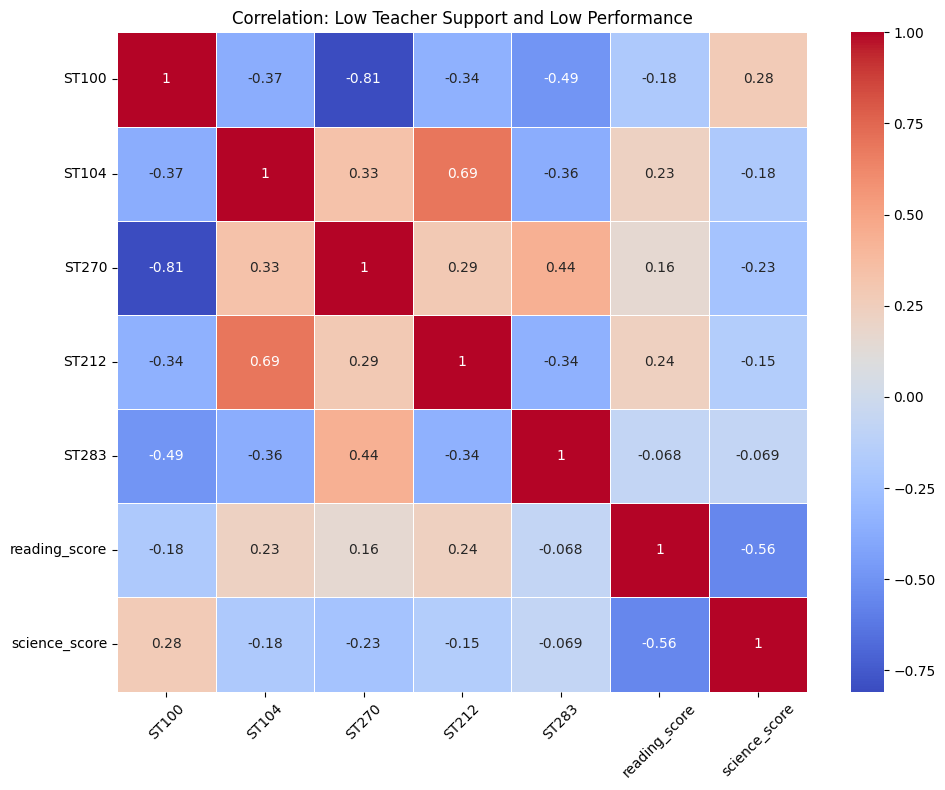

In [21]:
# Step 1: Select relevant variables for teacher support and performance
teacher_support = ['ST100', 'ST104', 'ST270', 'ST212', 'ST283']
performance = ['math_score', 'reading_score', 'science_score']

# Step 2: Check which columns actually exist and have data
cols_to_use = [col for col in teacher_support + performance 
               if col in df_cleaned.columns and df_cleaned[col].notna().sum() > 0]
print(f"Usable columns: {cols_to_use}")

# Step 3: Subset and drop remaining missing values
df_selected = df_cleaned[cols_to_use].dropna()
print(f"Rows after dropna: {len(df_selected)}")

# Step 4: Filter for low teacher support AND low performance (bottom 25%)
perf_cols = [col for col in performance if col in df_selected.columns]
support_cols = [col for col in teacher_support if col in df_selected.columns]
print(f"Performance columns available: {perf_cols}")
print(f"Teacher support columns available: {support_cols}")

avg_perf = df_selected[perf_cols].mean(axis=1)
avg_support = df_selected[support_cols].mean(axis=1)

low_perf_mask = avg_perf < avg_perf.quantile(0.25)
low_support_mask = avg_support < avg_support.quantile(0.25)

df_low_both = df_selected[low_perf_mask & low_support_mask]
print(f"Rows with both low support and low scores: {len(df_low_both)}")

# Step 5: Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_low_both), columns=df_low_both.columns)

# Step 6: Plot correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df_scaled.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation: Low Teacher Support and Low Performance")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()